### Title: VAR Models
Author: Chris Hyland

Date: 08-10-2018

##### Summary

- Bunch of data wrangling and producing datasets.


- The baseline model for this project is the random walk model, which gave us a MAPE of 20%.


- The VAR(1) performs terribly on the dataset. 

In [1]:
import pandas as pd, csv
import warnings
warnings.filterwarnings('ignore')

#### Reading in datasets.

In [2]:
data_products = pd.read_csv('../../intellify_data/products.csv')
data_products_dict = list(csv.DictReader(open('../../intellify_data/products.csv')))
stores = pd.read_csv('../../intellify_data/stores.csv')

In [3]:
data_stores = pd.read_csv('../../intellify_data/stores.csv', sep='\t')
data_stores_dict = list(csv.DictReader(open('../../intellify_data/stores.csv')))

In [4]:
data_transactions = pd.read_csv('../../intellify_data/transactions.csv')

#### Exploring data of interest.

In [5]:
# Get products we want to analyse.
product_of_interest = [1111087398, 1111087395, 1111087396]
transactions_of_int = data_transactions[data_transactions.UPC.isin(product_of_interest)]

In [6]:
print("Promotions occur {:.4f} of the time".format(len(transactions_of_int[transactions_of_int.BASE_PRICE == transactions_of_int.PRICE])/len(transactions_of_int)))

Promotions occur 0.7432 of the time


We will now work our to building a VAR model. These equations
predict a column vector of dependent variables using linear combinations of the lagged independent variables. This is based on the notion that the products are interrelated, which is indeed the case.

#### Data Wrangling.

In [7]:
from statsmodels.tsa.base.datetools import dates_from_str

In [8]:
# Now we make the assumption of aggregating the dataset.
agg_trans = transactions_of_int.groupby(['WEEK_END_DATE','UPC']).sum().reset_index(['WEEK_END_DATE','UPC'])

In [9]:
# Drop every column except product ID, units sold and date.
col_list = ['WEEK_END_DATE', 'UPC', 'UNITS']
agg_trans = agg_trans[col_list]

In [10]:
prod_one = agg_trans[agg_trans.UPC == 1111087398]
prod_two = agg_trans[agg_trans.UPC == 1111087395]
prod_three = agg_trans[agg_trans.UPC == 1111087396]

# Need to reset index to be able to add series together.
prod_two= prod_two.set_index(prod_one.index)
prod_three = prod_three.set_index(prod_one.index)

final_trans = pd.DataFrame()
final_trans["Prod_one"] = prod_one.UNITS
final_trans["Prod_two"] = prod_two.UNITS
final_trans["Prod_three"] = prod_three.UNITS
final_trans["Date"] = prod_one.WEEK_END_DATE

In [11]:
# First, fix ordering of dataset by time series.
weekly_date = dates_from_str(final_trans.Date)

final_trans.Date = weekly_date
final_trans["Date"] = pd.to_datetime(final_trans.Date)
final_trans = final_trans.sort_values(by="Date")

# Dataset is weekly data, so get datetime version to later set as index. 
weekly_date = final_trans.Date

# Update index to get datetime index.
final_trans.index = pd.DatetimeIndex(weekly_date)

del final_trans["Date"]

#### Testing Assumptions of model.

First part of a VAR model is that we require stationarity of the time series. We use the augmented Dickey fuller test. Recall that the null hypothesis is that we don't have a stationary time series, so a rejection suggests stationarity of the data.

In [12]:
from statsmodels.tsa.stattools import adfuller

products = ["Prod_one", "Prod_two", "Prod_three"]

"""
Run ADF test on each product and check test.
"""

for prod in products:
    print("P-value for {} is {:.5f}".format(prod, adfuller((final_trans[prod]))[1]))

P-value for Prod_one is 0.00000
P-value for Prod_two is 0.00000
P-value for Prod_three is 0.00000


We have stationarity!

In [13]:
from numpy import log

"""
Run ADF test on each logged product and print out p-value.
"""
for prod in products:
    print("P-value for {} is {:.5f}".format(prod, adfuller(log(final_trans[prod]))[1]))

P-value for Prod_one is 0.00000
P-value for Prod_two is 0.00000
P-value for Prod_three is 0.00000


##### Differencing dataset.
We try differencing the dataset now. Recall that $$difference(t) = observation(t) - observation(t-1).$$


In [14]:
len(final_trans.Prod_one)

156

In [15]:
def difference(dataset, interval=1):
    """
    Create and return a differenced series.
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

"""
Testing stationarity of differenced series.
"""

for prod in products:
    print("P-value for {} is {:.5f}".format(prod, adfuller(difference(final_trans[prod]))[1]))

P-value for Prod_one is 0.00000
P-value for Prod_two is 0.00000
P-value for Prod_three is 0.00000


Stationary after first difference.

In [16]:
# Testing stationarity of second ordered differenced series.
for prod in products:
    print("P-value for {} is {:.5f}".format(prod, adfuller(difference(difference(final_trans[prod])))[1]))

P-value for Prod_one is 0.00000
P-value for Prod_two is 0.00000
P-value for Prod_three is 0.00000


Let's try exploring the visualisation to see how else to identify it.

/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


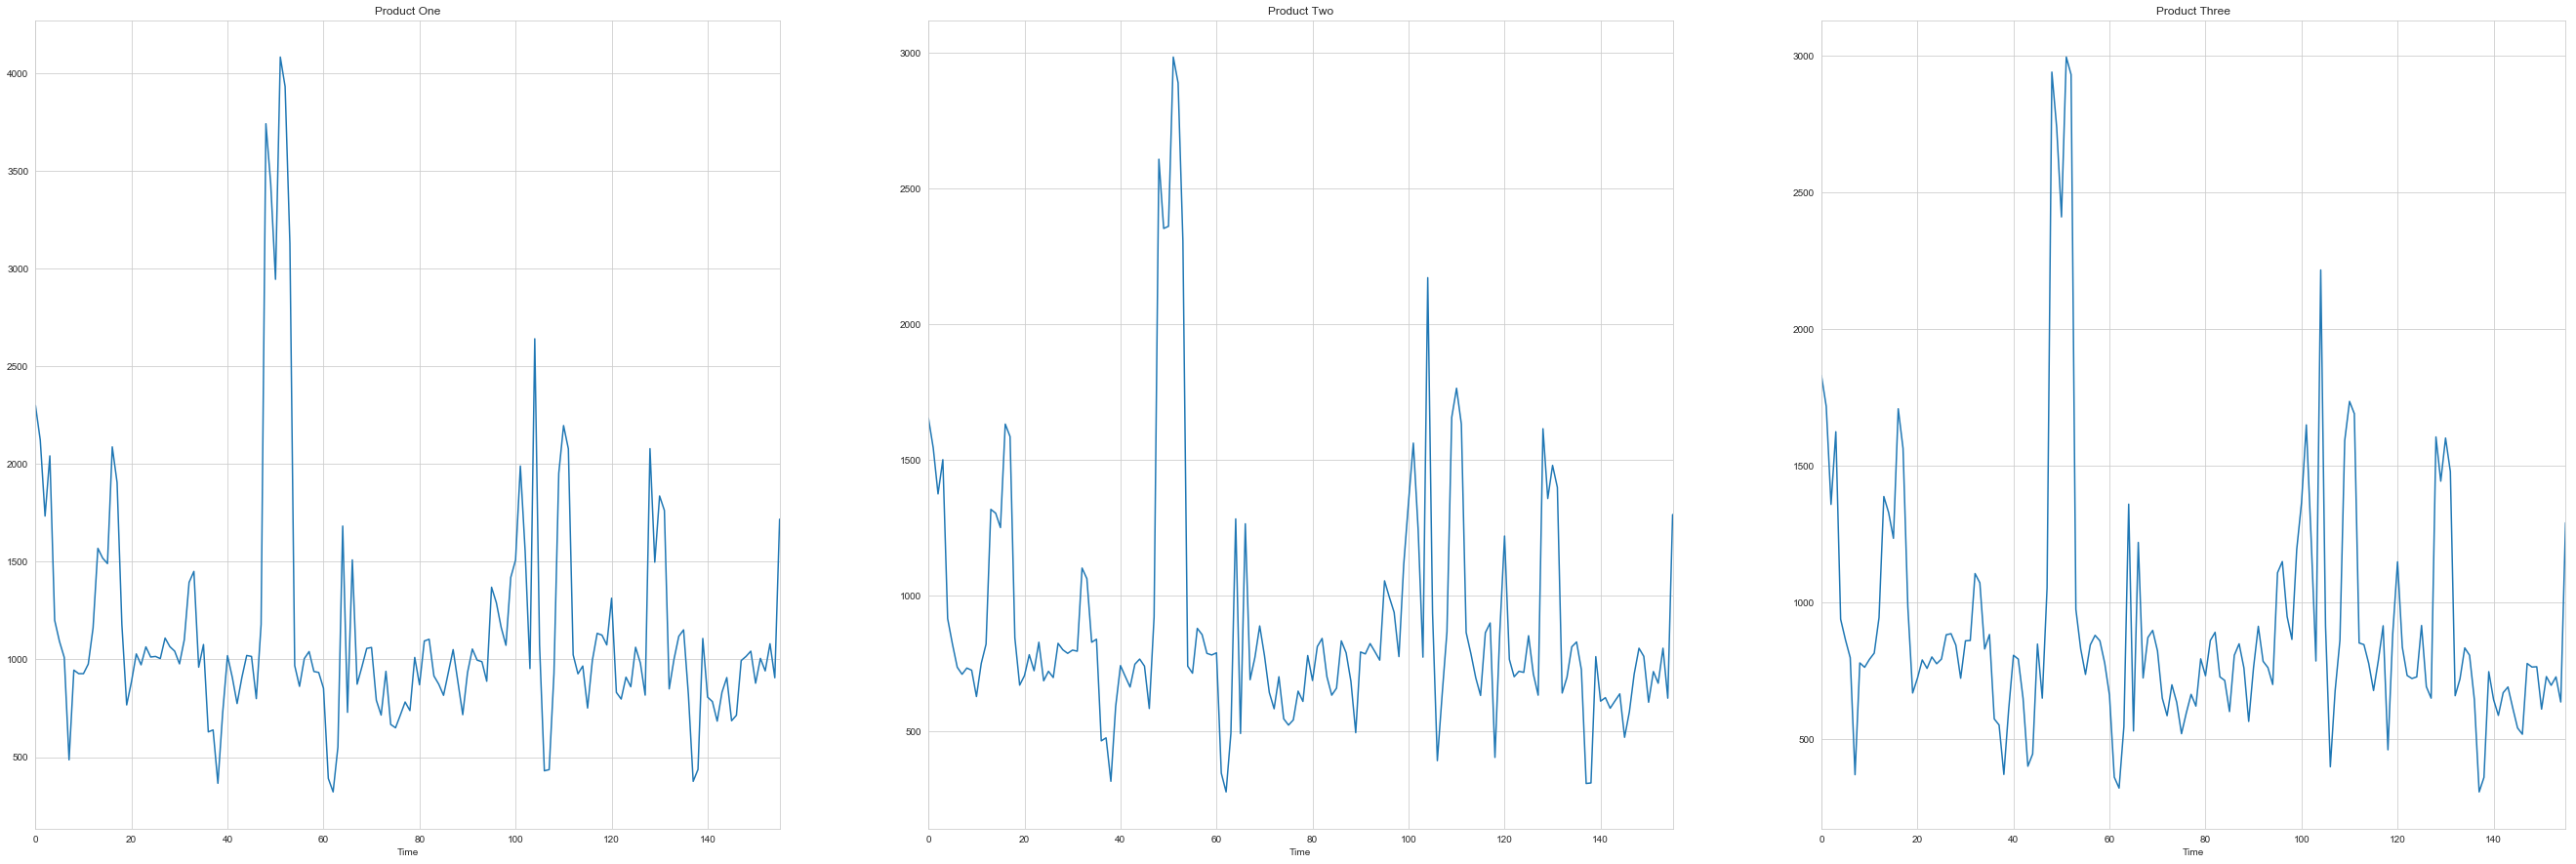

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

"""
Plot original data out.
"""
fig, axes = plt.subplots(nrows=1, ncols=3)

plt.subplot(1,3,1)
sns.tsplot(final_trans["Prod_one"])
plt.title("Product One")
plt.xlabel("Time")

plt.subplot(1,3,2)
sns.tsplot(final_trans["Prod_two"])
plt.title("Product Two")
plt.xlabel("Time")

plt.subplot(1,3,3)
sns.tsplot(final_trans["Prod_three"])
plt.title("Product Three")
plt.xlabel("Time")

# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


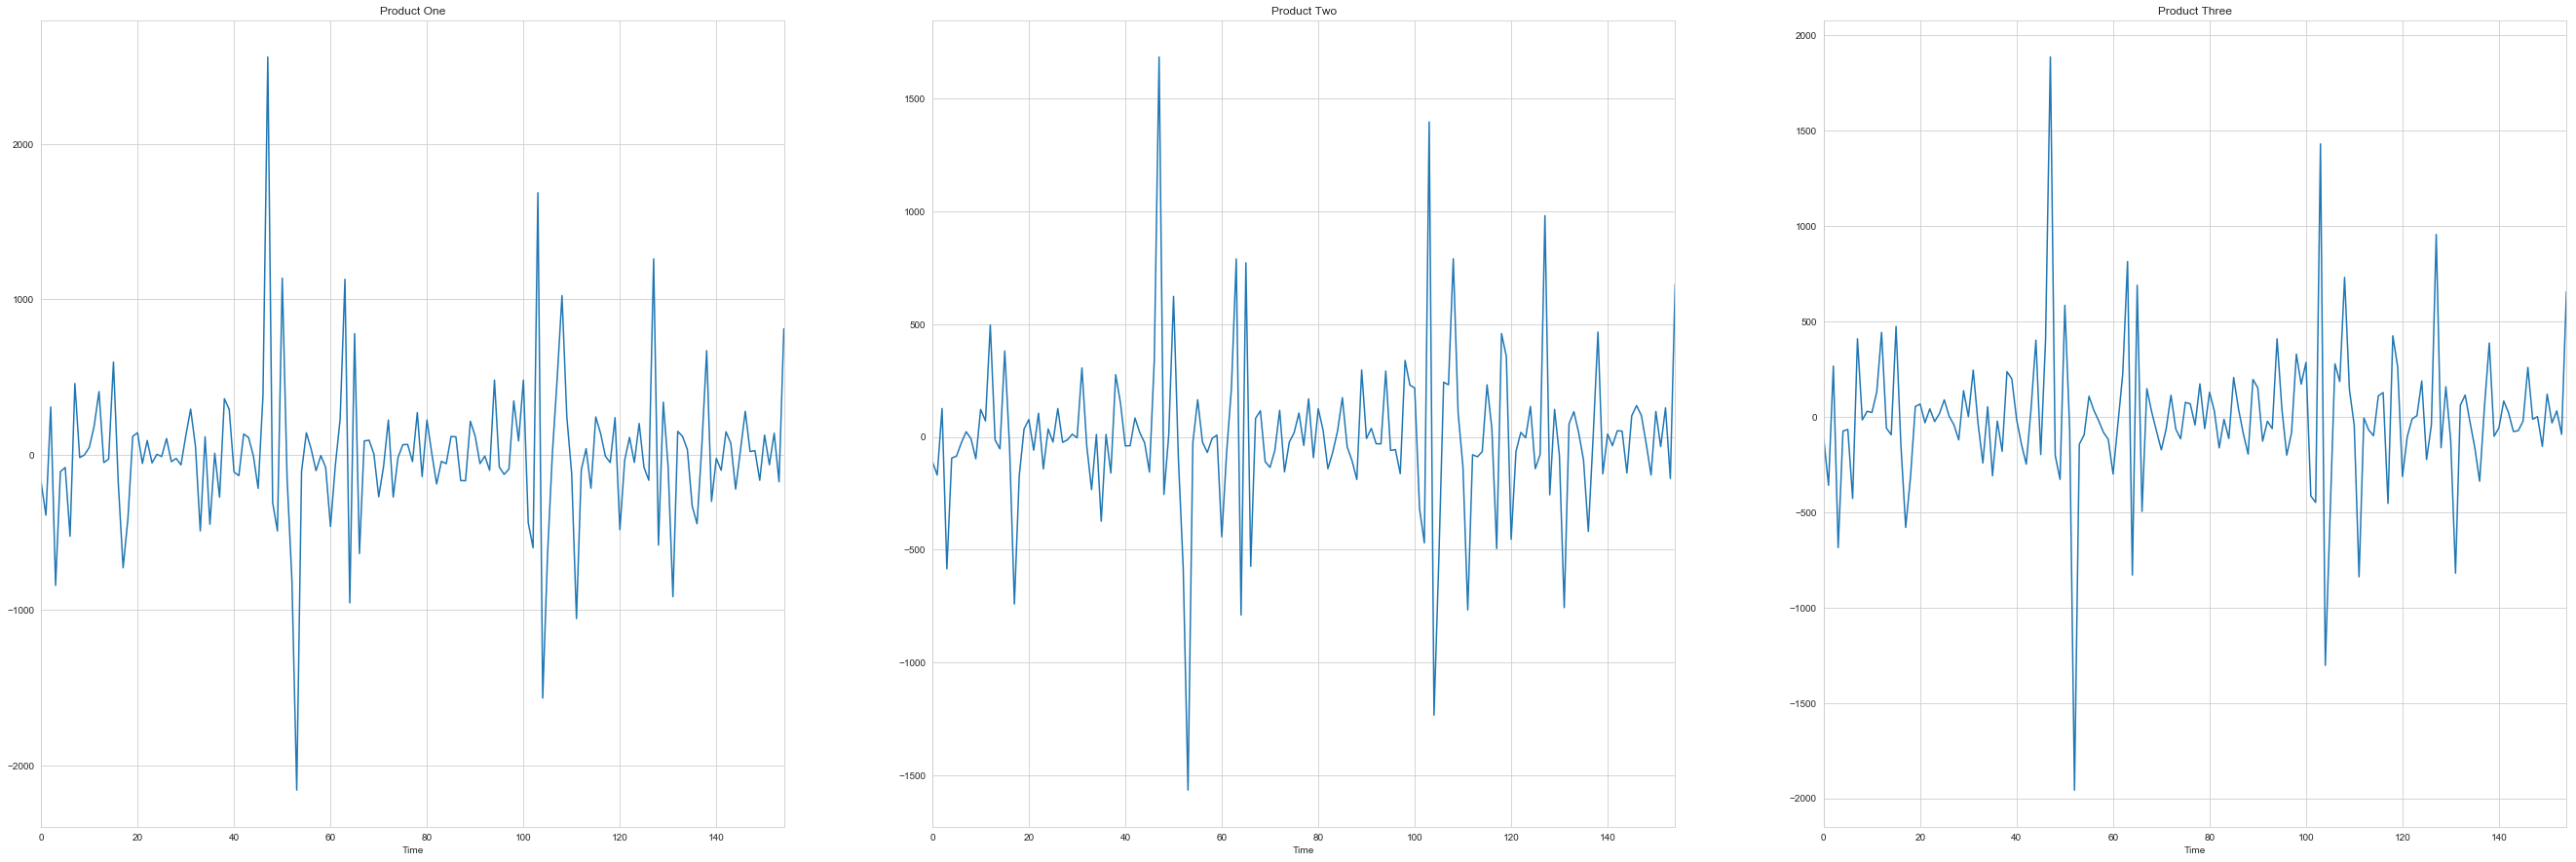

In [18]:
"""
Plot differenced data out.
"""
fig, axes = plt.subplots(nrows=1, ncols=3)

plt.subplot(1,3,1)
sns.tsplot(difference(final_trans["Prod_one"]))
plt.title("Product One")
plt.xlabel("Time")

plt.subplot(1,3,2)
sns.tsplot(difference(final_trans["Prod_two"]))
plt.title("Product Two")
plt.xlabel("Time")

plt.subplot(1,3,3)
sns.tsplot(difference(final_trans["Prod_three"]))
plt.title("Product Three")
plt.xlabel("Time")

# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

### Now analysing seasonal factors.

<Figure size 432x288 with 0 Axes>

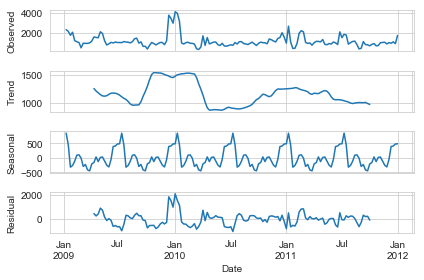

<Figure size 432x288 with 0 Axes>

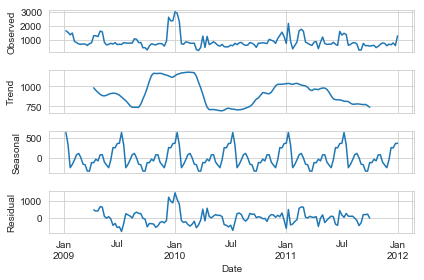

<Figure size 432x288 with 0 Axes>

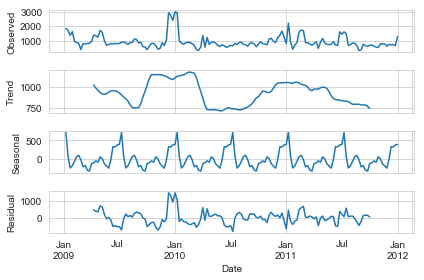

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

"""
Additive model by default

Frequency is 26, as our observation is weekly data
"""
#fig, axes = plt.subplots(nrows=1, ncols=3)

#plt.subplot(1,3,1)
res = seasonal_decompose(final_trans["Prod_one"], freq=26)
fig = plt.figure()  
fig = res.plot()
#plt.title("Product One")



#plt.subplot(1,3,2)
res = seasonal_decompose(final_trans["Prod_two"], freq=26)
fig = plt.figure()  
fig = res.plot()
#plt.title("Product Two")


#plt.subplot(1,3,3)
res = seasonal_decompose(final_trans["Prod_three"], freq=26)
fig = plt.figure()  
#plt.title("Product Three")
fig = res.plot()

High degree of seasonality here.

The seasonal variation seems not proportional to the trend, therefore we use the **additive model**

### Model Validation

Just running a few basic baseline models to try it out first.

In [20]:
# 80-20 train/validation split.
# Validation set will be from July 2011 onwards, as that is roughly 20% of the data.

train_data = final_trans[final_trans.index <= "2011-06-01"]
train_data1 = train_data[train_data.index >= '2010-01-27'] # clear outlier
val_data = final_trans[final_trans.index > "2011-06-01"]
#train_data1.to_csv('../../intellify_data/Train_data_halfYear.csv', index = True)

We decided to come up with a new metric rather than MSE in order to account for difference in units across products. That is, some products may be sold in higher quantities. Hence, we propose the MAPE.

MAPE: $$p_t=100*e_t/y_t$$.

In [21]:
def naive(products, train_data, val_data):
    """
    Naive/ Random Walk Model. Use y_{t-1} to predict y_t.
    
    Parameters
    ----------
    products : list of strings
        Names of products you want to look at.
    train_data: dataframe
        The training set containing all products.
    val_data: dataframe
        The validation set containing all products.
        
    Returns
    --------
    results : dictionary
        Key is product and value is the MSE.
    """
    results = {}
    for prod in products:
        # Compute metric for each product.
        diff = []
        # Just for the 1-step ahead forecast.
        diff.append(abs(train_data[prod].iloc[len(train_data[prod])-1] - val_data[prod].iloc[0])/abs(val_data[prod].iloc[0]))
        for i in range(1, len(val_data[prod])):
            # Loop through and use y_t-1 to predict y_t.
            # CHANGE THIS LINE TO CHANGE ERROR METRIC.
            diff.append(100*(abs(val_data[prod].iloc[i] - val_data[prod].iloc[i-1])/val_data[prod].iloc[i]))
        
        # Add the result to dictionary.
        results.update({prod: sum(diff)/len(diff)})
    
    return results
    
    

In [22]:
# Check results of model.
products = ["Prod_one", "Prod_two", "Prod_three"]
#products = ["Prod_one"]
naive_res = naive(products, train_data, val_data)

# Need to wrangle it in this fancy manner.
# https://thispointer.com/python-pandas-how-to-create-dataframe-from-dictionary/
pd.DataFrame(list(naive_res.items()), columns=['Product', 'MAPE'])

,Product,MAPE
0,Prod_one,25.382278
1,Prod_two,24.343264
2,Prod_three,22.688834


On average, our forecasts are roughly 22-25% of from using a Naive random walk method. In particular, we under forecast the actual number of products sold.

#### Fitting a VAR Model.

To choose number of lags, you can use the in built VAR function which uses information criteria-based order selection.

In [23]:
from statsmodels.tsa.api import VAR
# Fit the object on the dataset.
model = VAR(final_trans)

# Test AIC up to lag order of 12.
model.select_order(12).summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,31.60,31.66,5.305e+13,31.63
1,30.85,31.09*,2.490e+13,30.95*
2,30.88,31.31,2.569e+13,31.05
3,30.92,31.54,2.676e+13,31.17
4,30.87,31.67,2.543e+13,31.19
5,30.80*,31.79,2.389e+13*,31.20
6,30.85,32.03,2.518e+13,31.33
7,30.90,32.26,2.640e+13,31.45
8,30.97,32.51,2.842e+13,31.60
9,30.97,32.70,2.848e+13,31.67


It appears that a VAR(1) is recommended.

In [24]:
model = VAR(final_trans).fit(1)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [25]:
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Dec, 2018
Time:                     04:46:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    31.0664
Nobs:                     155.000    HQIC:                   30.9265
Log likelihood:          -3037.19    FPE:                2.45272e+13
AIC:                      30.8308    Det(Omega_mle):     2.27223e+13
--------------------------------------------------------------------
Results for equation Prod_one
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const               288.619685        77.322744            3.733           0.000
L1.Prod_one           0.227743         0.306026            0.744           0.457
L1.Prod_two          -0.313328         0.436219          

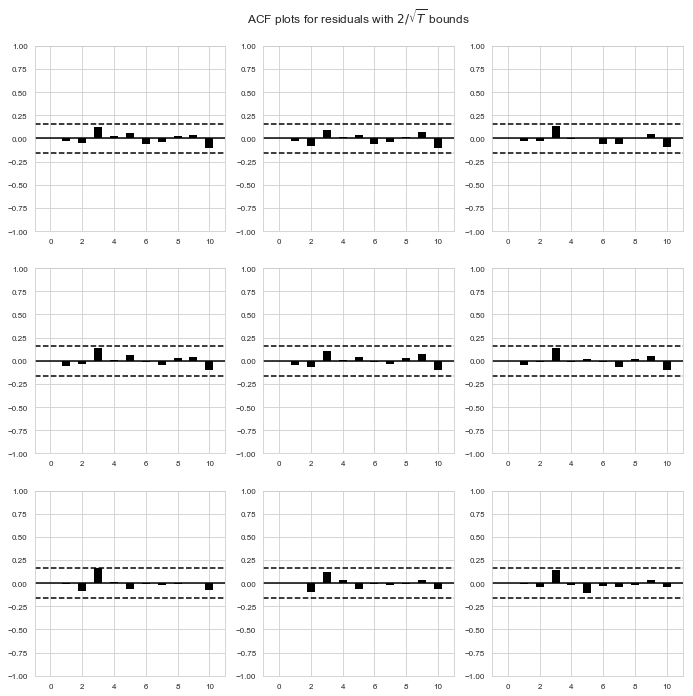

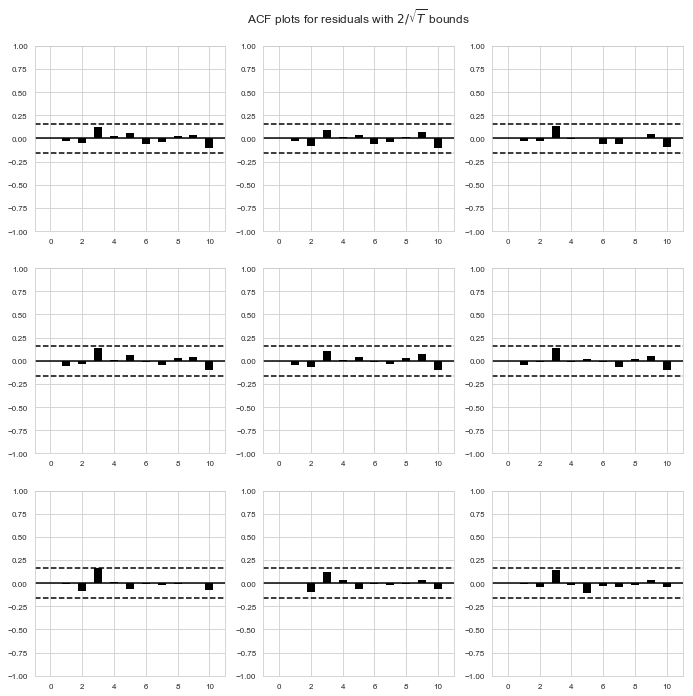

In [26]:
# Plotting the ACF.
model.plot_acorr()

#### In-Sample Granger Causality Test.
We can run a in-sample Granger Causality test, which is just an F-test placed on the coefficients on the lags of the model.

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests

products = ["Prod_one", "Prod_two", "Prod_three"]

# Iterating through and doing granger causality test.
for i in range(0,3):
    for j in range(i+1,3):
        print("Product {} and product {} ".format(i+1, j+1))
        grangercausalitytests(pd.concat([(final_trans[products[i]]),(final_trans[products[j]])], axis=1), maxlag=2).keys()
        print("\n\n\n")


Product 1 and product 2 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5349  , p=0.4657  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=0.5455  , p=0.4602  , df=1
likelihood ratio test: chi2=0.5445  , p=0.4606  , df=1
parameter F test:         F=0.5349  , p=0.4657  , df_denom=152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2542  , p=0.2883  , df_denom=149, df_num=2
ssr based chi2 test:   chi2=2.5925  , p=0.2736  , df=2
likelihood ratio test: chi2=2.5710  , p=0.2765  , df=2
parameter F test:         F=1.2542  , p=0.2883  , df_denom=149, df_num=2




Product 1 and product 3 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9515 , p=0.0003  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=14.2269 , p=0.0002  , df=1
likelihood ratio test: chi2=13.6114 , p=0.0002  , df=1
parameter F test:         F=13.9515 , p=0.0003  , df_denom=152, df_num=1

Granger Causality
number of lags (no ze

The null hypothesis here is that time series y DOES NOT Granger cause time series x. So a rejection would mean that it does.

### Forecasting with VAR Model.

In [28]:
# Fit the object on the dataset.
model = VAR(train_data)
model = model.fit(1) # Fitting an VAR(2) model

# Since VAR(1), need to pass in last 3 values of training set.
var_pred = model.forecast(train_data.values[-2:], len(val_data))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [29]:
"""
Checking results of VAR(2) prediction.
"""

products = ["Prod_one", "Prod_two", "Prod_three"]

results = {}
# Loop over a forecast product
for prod, prod_num in zip(products, range(0,3)):
    # Compute metric for each product.
    diff = []
    
    for time in range(0, len(val_data[prod])):

        # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(var_pred[time][prod_num] - val_data[prod].iloc[time])/val_data[prod].iloc[time]))

    # Add the result to dictionary.
    results.update({prod: sum(diff)/len(diff)})

In [30]:
pd.DataFrame(list(results.items()), columns=['Product', 'MAPE'])

,Product,MAPE
0,Prod_one,38.961776
1,Prod_two,44.996580
2,Prod_three,46.375840


VAR(1) model performs terribly. Massive overforecasting.

## Conclusion
First, we save our datasets elsewhere since they've been wrangled.

In [ ]:
train_data.to_csv("../../intellify_data/Train_data.csv", index=True)
val_data.to_csv("../../intellify_data/Val_data.csv", index=True)